# House Prices - Advanced Regression Techniques

In this competition, we want to **predict** the price of each house based on 79 variables that describe the residences located in Ames, Iowa. For more information about this competition, you can visit [here](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In this notebook, I tried to apply different machine learning algorithms for regression.

## 1. Introduction

In [1]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Preprocessing and machine learning
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [2]:
# Load data
df_train = pd.read_csv("C:/Users/Seyong Ryoo/OneDrive/Kaggle/Houses Prices/data/train.csv")
df_test = pd.read_csv("C:/Users/Seyong Ryoo/OneDrive/Kaggle/Houses Prices/data/test.csv", index_col='Id')
pd.set_option('display.max_rows', df_train.shape[0]+1)
print('The training data contains', df_train.shape[0], 'rows and', df_train.shape[1], 'columns.')
print('The training data contains', df_test.shape[0], 'rows and', df_test.shape[1], 'columns.')

The training data contains 1460 rows and 81 columns.
The training data contains 1459 rows and 79 columns.


In [3]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


A total of 19 variables have missing values.

In [4]:
print(df_train.isna().sum()[df_train.isna().sum() > 0])
print(df_train.isna().sum()[df_train.isna().sum() > 0].count())

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64
19


## 2. Variable selection

We selected only the variables that have the correlation with the dependent variable, `SalePrice`, larger than 0.5 or smaller than -0.5.

In [5]:
corr_ordered = df_train.corr().nlargest(81, 'SalePrice')['SalePrice']
corr_ordered_cut = corr_ordered[(corr_ordered > 0.5) | (corr_ordered < -0.5)]
print(corr_ordered_cut)
print('There are', len(corr_ordered_cut)-1, 'selected variables.')

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
Name: SalePrice, dtype: float64
There are 10 selected variables.


Then, with these features, we drew a heatmap to see how they are correlated and we dropped some features to avoid multicollinearity.  According to the heatmap, the correlation between `GarageCars` and `GarageArea` was 0.88 and we decided to drop `GarageArea` as its correlation with `SalePrice` is smaller. In the same way,  `1stFlrSF` and `TotRmsAbvGrd` were filtered out.

After creating a new training data where the irrelevant and the above-mentioned variables were deleted, we looked at whether there were missing values.

<AxesSubplot:>

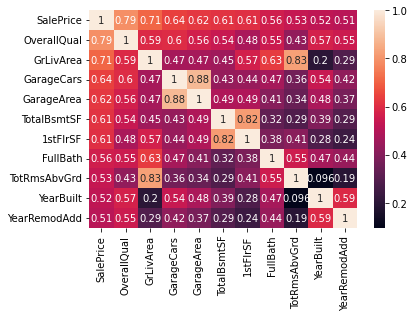

In [6]:
sns.heatmap(np.corrcoef(df_train[corr_ordered_cut.index].values.T), annot=True,
            xticklabels=corr_ordered_cut.index, yticklabels=corr_ordered_cut.index)

In [7]:
df_train_reduced = df_train[corr_ordered_cut.index.drop(['GarageArea', '1stFlrSF', 'TotRmsAbvGrd'])]
df_train_reduced.head()

,SalePrice,OverallQual,GrLivArea,GarageCars,TotalBsmtSF,FullBath,YearBuilt,YearRemodAdd
0,208500,7,1710,2,856,2,2003,2003
1,181500,6,1262,2,1262,2,1976,1976
2,223500,7,1786,2,920,2,2001,2002
3,140000,7,1717,3,756,1,1915,1970
4,250000,8,2198,3,1145,2,2000,2000


In [8]:
# No missing data
df_train_reduced.isna().sum()

SalePrice       0
OverallQual     0
GrLivArea       0
GarageCars      0
TotalBsmtSF     0
FullBath        0
YearBuilt       0
YearRemodAdd    0
dtype: int64

In [9]:
df_train_reduced.dtypes

SalePrice       int64
OverallQual     int64
GrLivArea       int64
GarageCars      int64
TotalBsmtSF     int64
FullBath        int64
YearBuilt       int64
YearRemodAdd    int64
dtype: object

In [10]:
# Split into dependent variable and design matrix
y_train = df_train_reduced['SalePrice']
X_train= df_train_reduced.drop('SalePrice', axis=1)

## 3. Preprocessing

Before applying several regression models that might help explain `SalePrice` using the covariates in the design matrix, we standardized the training data by using a scaler which is robust to outliers. You can find more information about the robust scaler [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html).

In [11]:
# Standardization
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)

## 1. [Linear regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

Linear regression tries to explain the relationship between the dependent variable and covariates using a linear function of the covariates.

In [12]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
rmse_lm = np.sqrt(-cross_val_score(lm, X_train, y_train, cv=5, scoring='neg_mean_squared_error')).mean()
print('The root mean squared error using linear regression:', round(rmse_lm, 4))

The root mean squared error using linear regression: 38454.6432


## 2. [Stochastic Gradient Descent (SGD) Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html#sklearn.linear_model.SGDRegressor)

This regressor fits a regularized linear model by minimizing a loss with SGD learning.

In [13]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

from sklearn.linear_model import SGDRegressor
sgd = SGDRegressor(random_state=0)
param_grid_sgd = [{'loss': ['squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
                  'penalty': ['l2', 'l1', 'elasticnet']}]
grid_sgd = GridSearchCV(sgd, param_grid_sgd, cv=5, scoring='neg_mean_squared_error')
grid_sgd.fit(X_train, y_train)
print(grid_sgd.best_params_)
print(np.sqrt(-grid_sgd.best_score_))
print('The root mean squared error using SGD regression:', round(np.sqrt(-grid_sgd.best_score_), 4))

{'loss': 'squared_loss', 'penalty': 'l2'}
38946.10115660087
The root mean squared error using SGD regression: 38946.1012


## 3. [Multi-Layer Perceptron (MLP) Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor)

In [14]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(random_state=0)
param_grid_mlp = [{'hidden_layer_sizes': [(5,), (10,)],
                  'activation': ['identity', 'logistic', 'tanh', 'relu'],
                  'solver': ['lbfgs', 'sgd', 'adam'],
                  'max_iter': [200, 1000, 5000, 10000]}]
grid_mlp = GridSearchCV(mlp, param_grid_mlp, cv=5, scoring='neg_mean_squared_error')
grid_mlp.fit(X_train, y_train)
print('The root mean squared error using MLP regression:', round(np.sqrt(-grid_mlp.best_score_),4))
print(grid_mlp.best_params_)

The root mean squared error using MLP regression: 38794.666
{'activation': 'relu', 'hidden_layer_sizes': (5,), 'max_iter': 200, 'solver': 'lbfgs'}


## 4. [Linear Support Vector Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVR.html#sklearn.svm.LinearSVR)

In [15]:
from sklearn.svm import LinearSVR
lsvr = LinearSVR(random_state=0)
param_grid_lsvr = [{'C': [0.001, 0.1, 1, 5],
                   'loss': ['epsilon_insensitive', 'squared_epsilon_insensitive'],
                   'max_iter': [20000, 50000]}]
grid_lsvr = GridSearchCV(lsvr, param_grid_lsvr, cv=5, scoring='neg_mean_squared_error')
grid_lsvr.fit(X_train, y_train)
print('The root mean squared error using linear support vector regression:', round(np.sqrt(-grid_lsvr.best_score_),4))
print(grid_lsvr.best_params_)

The root mean squared error using linear support vector regression: 38946.0389
{'C': 1, 'loss': 'squared_epsilon_insensitive', 'max_iter': 20000}


## 5. [Random Forest Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor)

In [16]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state=0, n_jobs=-1)
param_grid_rf = [{'n_estimators': [10, 50, 100],
                'criterion': ['mse', 'mae'],
                'max_depth': [None, 5, 10, 20], 
                'max_features': ['auto', 'sqrt', 'log2']}]
grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='neg_mean_squared_error')
grid_rf.fit(X_train, y_train)
print('The root mean squared error using random forest regression:', round(np.sqrt(-grid_rf.best_score_),4))
print(grid_rf.best_params_)

The root mean squared error using random forest regression: 30858.548
{'criterion': 'mae', 'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 50}


From the table below that shows the root mean squared error using the regressors, we conclude that the random forest regression technique produced the best performance, that is, the smallest error. Then, we used this algorithm on the test data to predict `SalePrice`.

In [17]:
pd.DataFrame([np.sqrt(-grid_sgd.best_score_), np.sqrt(-grid_mlp.best_score_),np.sqrt(-grid_lsvr.best_score_), np.sqrt(-grid_rf.best_score_)],
             index = ['SGD', 'MLP', 'Linear SVM', 'Random Forest'], columns = ['RMSE'])

,RMSE
SGD,38946.101157
MLP,38794.666006
Linear SVM,38946.038854
Random Forest,30858.548011


In [18]:
X_test = df_test.loc[:, ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt', 'YearRemodAdd']]

# Transforming test data
print(X_test.isna().sum())

fill = {'GarageCars': df_train['GarageCars'].median(), 'TotalBsmtSF': df_train['TotalBsmtSF'].median()}
X_test.fillna(fill, inplace=True)

X_test_transform = scaler.transform(X_test)

OverallQual     0
GrLivArea       0
GarageCars      1
TotalBsmtSF     1
FullBath        0
YearBuilt       0
YearRemodAdd    0
dtype: int64


In [19]:
# Apply the algorithm on the transformed test data
y_predicted = pd.DataFrame({'SalePrice': grid_rf.predict(X_test_transform)}, index=X_test.index)
y_predicted.head()

,SalePrice
Id,
1461,115037.66
1462,141460.00
1463,180080.40
1464,181432.00
1465,187866.00


In [20]:
y_predicted.to_csv('submission_rf.csv')